In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from glob import glob
import re
import librosa
import librosa.display
import warnings
import soundfile as sf


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Image Data loading and Processing

In [24]:
IMAGE_DIR = '/content/drive/MyDrive/Formative2-DataPreprocessing/images'
OUTPUT_CSV = '/content/image_features.csv'  # Save to /content/ directory (writable)
IMAGE_SIZE = (128, 128)
DISPLAY_EXPRESSION = 'smiling'  # Only display this expression (use 'all' to show everything)

AUDIO_DIR = '/content/drive/MyDrive/Formative2-DataPreprocessing/audio'  # Update this path
OUTPUT_CSV = '/content/audio_features.csv'  # Writable location in Colab
SAMPLE_RATE = 22050  # Standard sample rate for audio processing
DISPLAY_TYPE = 'approve'  # Display 'approve', 'confirm', or 'all'


In [10]:
def parse_filename(filename):
    """Extract member name and expression from filename"""
    basename = os.path.splitext(os.path.basename(filename))[0]
    # Split by last hyphen to handle names with hyphens
    parts = basename.rsplit('-', 1)
    if len(parts) == 2:
        return parts[0], parts[1]
    return basename, 'unknown'

In [24]:
extensions = ['*.jpg', '*.jpeg', '*.JPG', '*.JPEG']
image_paths = []
for ext in extensions:
    image_paths.extend(glob(os.path.join(IMAGE_DIR, ext)))

images_data = []
for path in image_paths:
    img = cv2.imread(path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        member, expression = parse_filename(path)
        images_data.append({
            'path': path,
            'image': img,
            'member': member,
            'expression': expression
        })


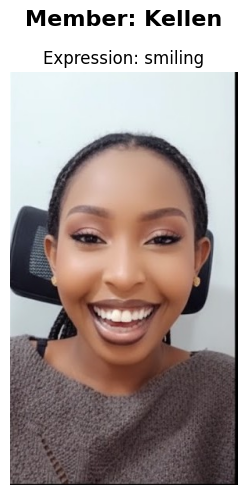

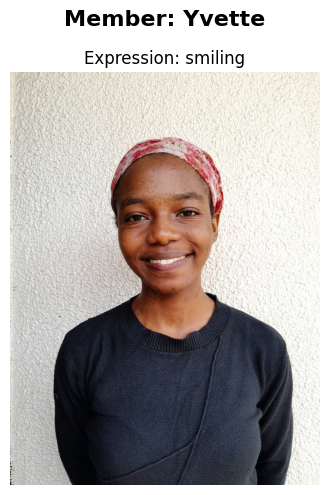

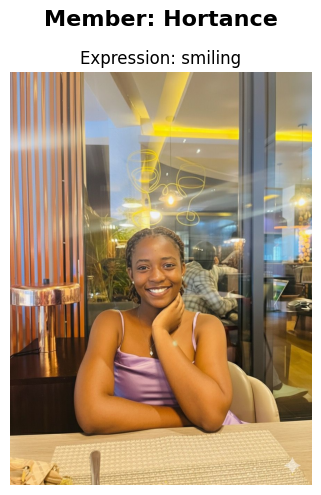

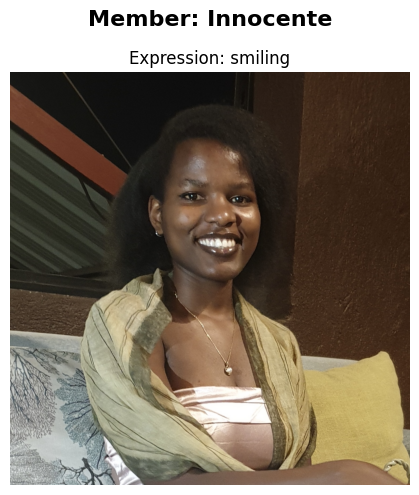

In [25]:
images_data_toDisplay = [img for img in images_data if img['expression'].lower() == 'smiling']

members = {}
for img_data in images_data_toDisplay:
    member = img_data['member']
    if member not in members:
        members[member] = []
    members[member].append(img_data)

# Display samples
for member, imgs in members.items():
    n_images = len(imgs)
    cols = min(3, n_images)
    rows = (n_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    fig.suptitle(f'Member: {member}', fontsize=16, fontweight='bold')

    if n_images == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if rows > 1 else axes

    for idx, img_data in enumerate(imgs):
        if idx < len(axes):
            axes[idx].imshow(img_data['image'])
            axes[idx].set_title(f"Expression: {img_data['expression']}")
            axes[idx].axis('off')

    # Hide extra subplots
    for idx in range(n_images, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

In [13]:
def augment_image(img):
    """Apply various augmentations to an image"""
    augmentations = {}

    # Original (resized)
    img_resized = cv2.resize(img, IMAGE_SIZE)
    augmentations['original'] = img_resized

    # Rotation (15 degrees)
    h, w = img_resized.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, 15, 1.0)
    augmentations['rotated'] = cv2.warpAffine(img_resized, matrix, (w, h))

    # Horizontal flip
    augmentations['flipped'] = cv2.flip(img_resized, 1)

    # Grayscale
    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    augmentations['grayscale'] = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

    # Brightness adjustment
    hsv = cv2.cvtColor(img_resized, cv2.COLOR_RGB2HSV)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * 1.2, 0, 255)
    augmentations['brightness'] = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return augmentations

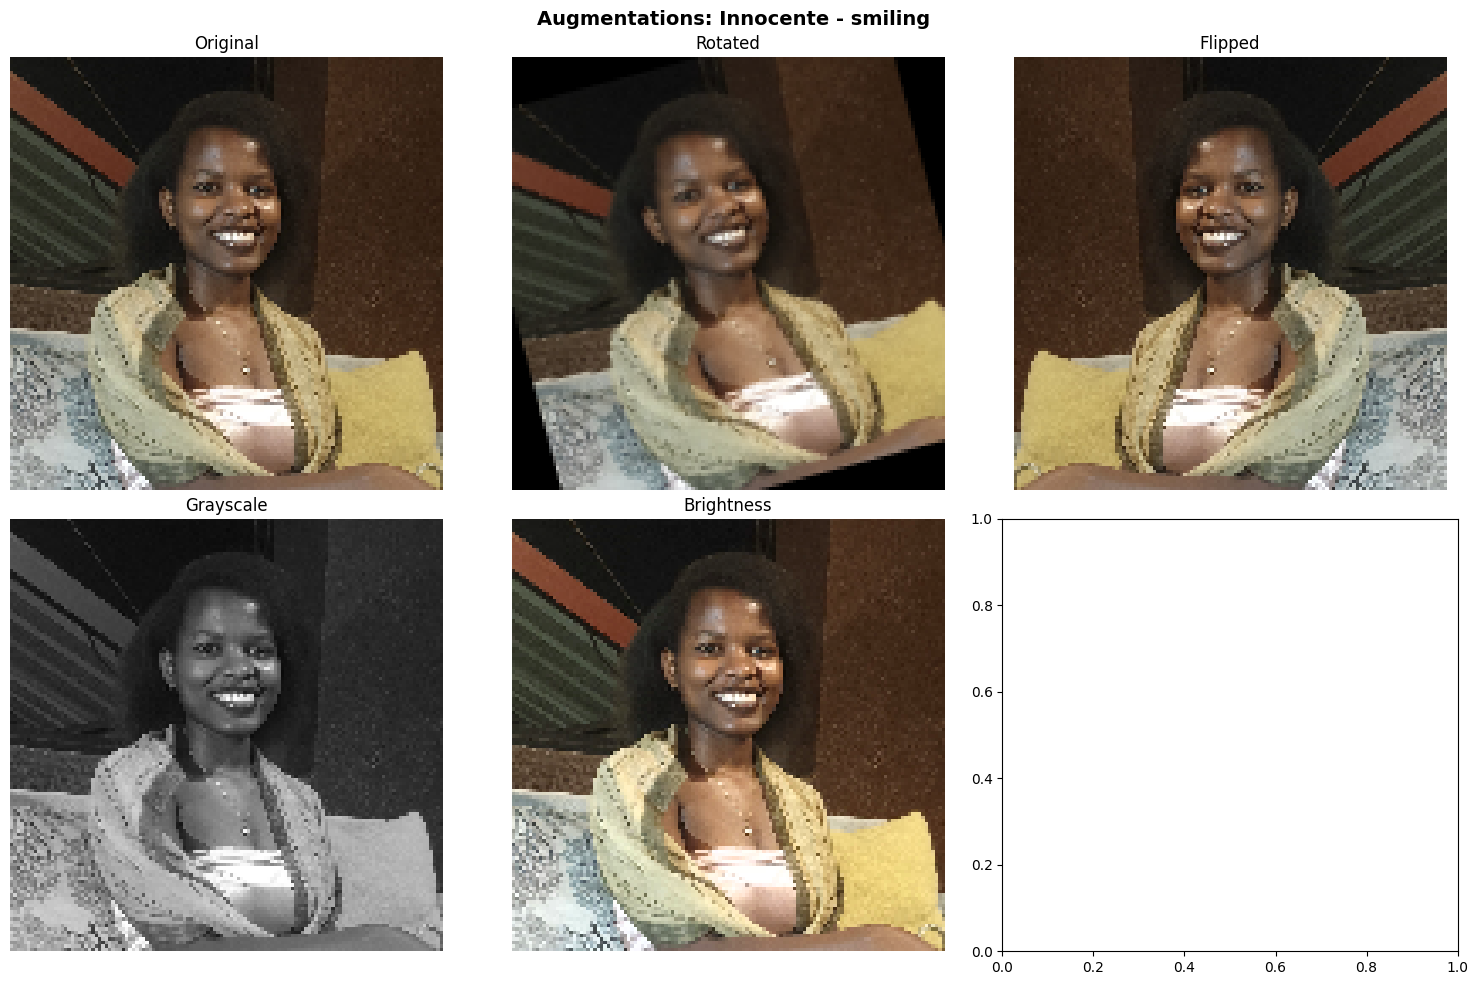

In [16]:
augmentations = augment_image(img_data['image'])

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle(f"Augmentations: {img_data['member']} - {img_data['expression']}",
              fontsize=14, fontweight='bold')

axes = axes.flatten()
for idx, (aug_name, aug_img) in enumerate(augmentations.items()):
    if idx < len(axes):
        axes[idx].imshow(aug_img)
        axes[idx].set_title(aug_name.capitalize())
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [17]:
def extract_color_histogram(img, bins=32):
    """Extract color histogram features"""
    features = []
    for channel in range(3):
        hist = cv2.calcHist([img], [channel], None, [bins], [0, 256])
        hist = hist.flatten() / hist.sum()  # Normalize
        features.extend(hist)
    return features

def extract_texture_features(img):
    """Extract texture features using Laplacian"""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    features = [
        np.mean(laplacian),
        np.std(laplacian),
        np.min(laplacian),
        np.max(laplacian)
    ]
    return features

def extract_shape_features(img):
    """Extract basic shape/edge features"""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    features = [
        np.mean(edges),
        np.std(edges),
        np.sum(edges > 0)  # Edge pixel count
    ]
    return features

def extract_all_features(img):
    """Combine all feature extraction methods"""
    img_resized = cv2.resize(img, IMAGE_SIZE)

    features = []
    features.extend(extract_color_histogram(img_resized))
    features.extend(extract_texture_features(img_resized))
    features.extend(extract_shape_features(img_resized))

    return features

In [26]:
all_features = []

print(f"Processing {len(images_data)} images...")

for idx, img_data in enumerate(images_data):
    # Extract features from original image
    features = extract_all_features(img_data['image'])

    # Apply augmentations and extract features
    augmentations = augment_image(img_data['image'])

    for aug_name, aug_img in augmentations.items():
        aug_features = extract_all_features(aug_img)

        feature_row = {
            'member': img_data['member'],
            'expression': img_data['expression'],
            'augmentation': aug_name,
            'filename': os.path.basename(img_data['path'])
        }

        # Add features with column names
        for i, feat in enumerate(aug_features):
            feature_row[f'feature_{i}'] = feat

        all_features.append(feature_row)

    if (idx + 1) % 10 == 0:
        print(f"Processed {idx + 1}/{len(images_data)} images...")

# Create DataFrame and save
df = pd.DataFrame(all_features)
df.to_csv(OUTPUT_CSV, index=False)
print(f"\n✓ Features saved to {OUTPUT_CSV}")
print(f"✓ You can download it from the Colab files panel on the left")
print(f"✓ Total feature rows: {len(df)}")
print(f"✓ Feature dimensions: {len([col for col in df.columns if col.startswith('feature_')])}")


Processing 12 images...
Processed 10/12 images...

✓ Features saved to /content/image_features.csv
✓ You can download it from the Colab files panel on the left
✓ Total feature rows: 60
✓ Feature dimensions: 103


In [5]:
def parse_audio_filename(filename):
    """Extract member name and command type from filename"""
    basename = os.path.splitext(os.path.basename(filename))[0]
    # Split by last hyphen to handle names with hyphens
    parts = basename.rsplit('-', 1)
    if len(parts) == 2:
        return parts[0], parts[1]
    return basename, 'unknown'

In [22]:
def load_audio_files(audio_dir):
    """Load all audio files from directory"""
    extensions = ['*.mp3', '*.wav', '*.m4a', '*.MP3', '*.WAV', '*.M4A']
    audio_paths = []
    for ext in extensions:
        audio_paths.extend(glob(os.path.join(audio_dir, ext)))

    audio_data = []
    print("Loading audio files...")
    for path in audio_paths:
        try:
            # Load audio with librosa
            y, sr = librosa.load(path, sr=SAMPLE_RATE)
            member, command = parse_audio_filename(path)
            audio_data.append({
                'path': path,
                'audio': y,
                'sample_rate': sr,
                'member': member,
                'command': command,
                'duration': len(y) / sr
            })
            print(f"✓ Loaded: {os.path.basename(path)} ({len(y)/sr:.2f}s)")
        except Exception as e:
            print(f"✗ Failed to load {os.path.basename(path)}: {e}")

    return audio_data


In [9]:
def plot_waveform(y, sr, title):
    """Plot waveform of audio signal"""
    plt.figure(figsize=(12, 3))
    librosa.display.waveshow(y, sr=sr, alpha=0.8)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

In [10]:
def plot_spectrogram(y, sr, title):
    """Plot mel spectrogram of audio signal"""
    plt.figure(figsize=(12, 4))

    # Compute mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Display spectrogram
    img = librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='viridis')
    plt.colorbar(img, format='%+2.0f dB')
    plt.title(title, fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [15]:
def display_audio_samples(audio_data, command_filter=None):
    """Display waveforms and spectrograms for audio samples"""
    # Filter by command if specified
    filtered_data = audio_data
    if command_filter and command_filter.lower() != 'all':
        filtered_data = [a for a in audio_data if a['command'].lower() == command_filter.lower()]
        if len(filtered_data) == 0:
            print(f"❌ No audio found with command: {command_filter}")
            available = set([a['command'] for a in audio_data])
            print(f"Available commands: {available}")
            return

    print(f"\nDisplaying audio samples (Command: {command_filter})...\n")

    for audio_info in filtered_data:
        member = audio_info['member']
        command = audio_info['command']
        y = audio_info['audio']
        sr = audio_info['sample_rate']
        duration = audio_info['duration']

        print(f"{'='*60}")
        print(f"Member: {member} | Command: {command} | Duration: {duration:.2f}s")
        print(f"{'='*60}")

        # Plot waveform
        plot_waveform(y, sr, f"Waveform: {member} - {command}")

        # Plot spectrogram
        plot_spectrogram(y, sr, f"Mel Spectrogram: {member} - {command}")

        print()

In [16]:
def augment_pitch_shift(y, sr, n_steps=2):
    """Shift pitch by n_steps semitones"""
    return librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)

def augment_time_stretch(y, rate=1.2):
    """Stretch or compress time by rate"""
    return librosa.effects.time_stretch(y=y, rate=rate)

def augment_add_noise(y, noise_factor=0.005):
    """Add Gaussian noise to audio"""
    noise = np.random.randn(len(y))
    augmented = y + noise_factor * noise
    return augmented

def augment_change_speed(y, speed_factor=0.9):
    """Change playback speed"""
    return librosa.effects.time_stretch(y=y, rate=speed_factor)

def apply_augmentations(y, sr):
    """Apply multiple augmentations to audio"""
    augmentations = {}

    # Original
    augmentations['original'] = y

    # Pitch shift (up 2 semitones)
    augmentations['pitch_shift'] = augment_pitch_shift(y, sr, n_steps=2)

    # Time stretch (20% faster)
    augmentations['time_stretch'] = augment_time_stretch(y, rate=1.2)

    # Add background noise
    augmentations['add_noise'] = augment_add_noise(y, noise_factor=0.005)

    # Speed change (10% slower)
    augmentations['speed_change'] = augment_change_speed(y, speed_factor=0.9)

    return augmentations

In [17]:
def display_augmentations(audio_info):
    """Display augmentations for a sample audio"""
    y = audio_info['audio']
    sr = audio_info['sample_rate']
    member = audio_info['member']
    command = audio_info['command']

    print(f"\n{'='*60}")
    print(f"Augmentations Preview: {member} - {command}")
    print(f"{'='*60}\n")

    augmentations = apply_augmentations(y, sr)

    for aug_name, aug_audio in augmentations.items():
        print(f"--- {aug_name.upper().replace('_', ' ')} ---")
        plot_waveform(aug_audio, sr, f"{member} - {command} ({aug_name})")


In [18]:
def extract_mfcc_features(y, sr, n_mfcc=13):
    """Extract MFCC (Mel-frequency cepstral coefficients) features"""
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # Calculate statistics across time
    mfcc_mean = np.mean(mfccs, axis=1)
    mfcc_std = np.std(mfccs, axis=1)
    return np.concatenate([mfcc_mean, mfcc_std])

def extract_spectral_features(y, sr):
    """Extract spectral features"""
    # Spectral centroid
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

    # Spectral rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]

    # Spectral bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]

    # Zero crossing rate
    zero_crossing = librosa.feature.zero_crossing_rate(y)[0]

    features = [
        np.mean(spectral_centroids),
        np.std(spectral_centroids),
        np.mean(spectral_rolloff),
        np.std(spectral_rolloff),
        np.mean(spectral_bandwidth),
        np.std(spectral_bandwidth),
        np.mean(zero_crossing),
        np.std(zero_crossing)
    ]

    return features

In [19]:
def extract_energy_features(y):
    """Extract energy-based features"""
    # RMS Energy
    rms = librosa.feature.rms(y=y)[0]

    features = [
        np.mean(rms),
        np.std(rms),
        np.max(rms),
        np.min(rms)
    ]

    return features

def extract_tempo_features(y, sr):
    """Extract tempo and rhythm features"""
    # Tempo
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr)

    features = [
        tempo,
        len(beats)  # Number of beats
    ]

    return features

def extract_all_features(y, sr):
    """Combine all feature extraction methods"""
    features = []

    # MFCC features (26 features: 13 means + 13 stds)
    features.extend(extract_mfcc_features(y, sr))

    # Spectral features (8 features)
    features.extend(extract_spectral_features(y, sr))

    # Energy features (4 features)
    features.extend(extract_energy_features(y))

    # Tempo features (2 features)
    features.extend(extract_tempo_features(y, sr))

    return features

In [20]:
def process_and_save_features(audio_data):
    """Process all audio files and save features to CSV"""
    all_features = []

    print(f"\nProcessing {len(audio_data)} audio files...\n")

    for idx, audio_info in enumerate(audio_data):
        y = audio_info['audio']
        sr = audio_info['sample_rate']

        # Apply augmentations
        augmentations = apply_augmentations(y, sr)

        for aug_name, aug_audio in augmentations.items():
            # Extract features
            features = extract_all_features(aug_audio, sr)

            feature_row = {
                'member': audio_info['member'],
                'command': audio_info['command'],
                'augmentation': aug_name,
                'filename': os.path.basename(audio_info['path']),
                'duration': len(aug_audio) / sr
            }

            # Add features with column names
            for i, feat in enumerate(features):
                feature_row[f'feature_{i}'] = feat

            all_features.append(feature_row)

        print(f"✓ Processed {idx + 1}/{len(audio_data)}: {audio_info['member']} - {audio_info['command']}")

    # Create DataFrame and save
    df = pd.DataFrame(all_features)
    df.to_csv(OUTPUT_CSV, index=False)

    print(f"\n{'='*60}")
    print(f"✓ Features saved to {OUTPUT_CSV}")
    print(f"✓ You can download it from the Colab files panel on the left")
    print(f"✓ Total feature rows: {len(df)}")
    print(f"✓ Feature dimensions: {len([col for col in df.columns if col.startswith('feature_')])}")
    print(f"{'='*60}")

    return df

AUDIO PROCESSING & FEATURE EXTRACTION PIPELINE

1. Loading audio files...
Loading audio files...
✓ Loaded: Kellen-confirm.mp3 (2.35s)
✓ Loaded: Kellen-approve.mp3 (1.61s)
✓ Loaded: Hortance-approve.wav (3.24s)
✓ Loaded: Hortance-confirm.wav (3.06s)


/tmp/ipython-input-3912609411.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=SAMPLE_RATE)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


✓ Loaded: Yvette-approve.m4a (2.99s)


/tmp/ipython-input-3912609411.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=SAMPLE_RATE)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


✓ Loaded: Yvette-confirm.m4a (3.11s)


/tmp/ipython-input-3912609411.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=SAMPLE_RATE)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


✓ Loaded: Innocente-approve.m4a (2.58s)


/tmp/ipython-input-3912609411.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=SAMPLE_RATE)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


✓ Loaded: Innocente-confirm.m4a (2.20s)

✓ Loaded 8 audio files

Members found: {'Kellen', 'Yvette', 'Innocente', 'Hortance'}
Commands found: {'approve', 'confirm'}

2. Displaying audio samples...

Displaying audio samples (Command: approve)...

Member: Kellen | Command: approve | Duration: 1.61s


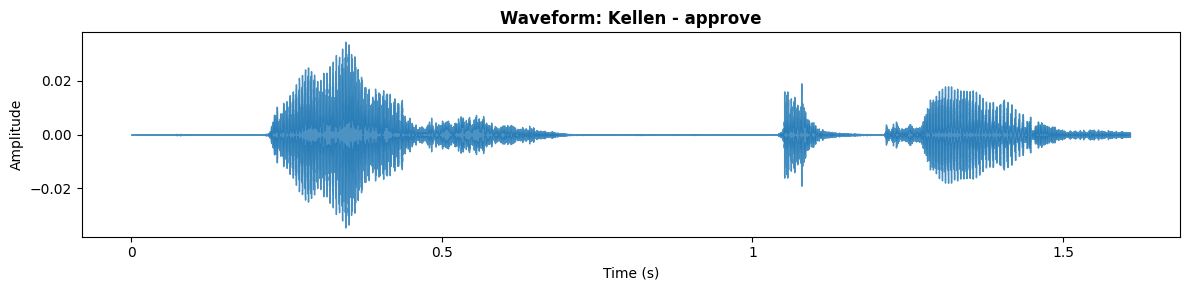

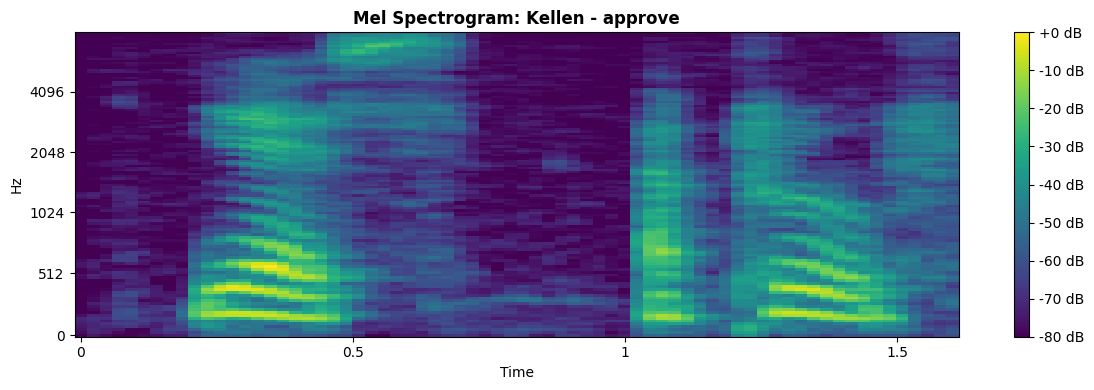


Member: Hortance | Command: approve | Duration: 3.24s


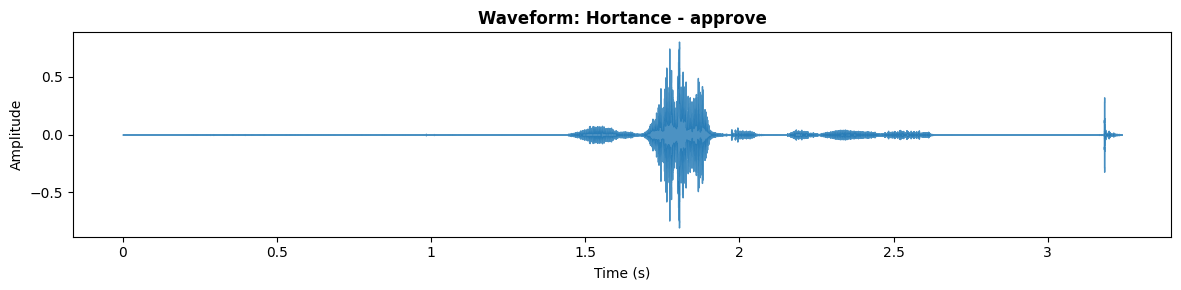

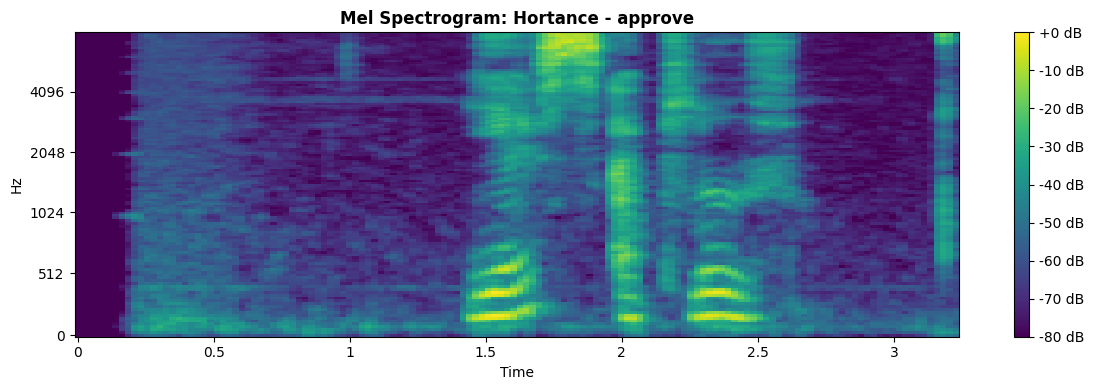


Member: Yvette | Command: approve | Duration: 2.99s


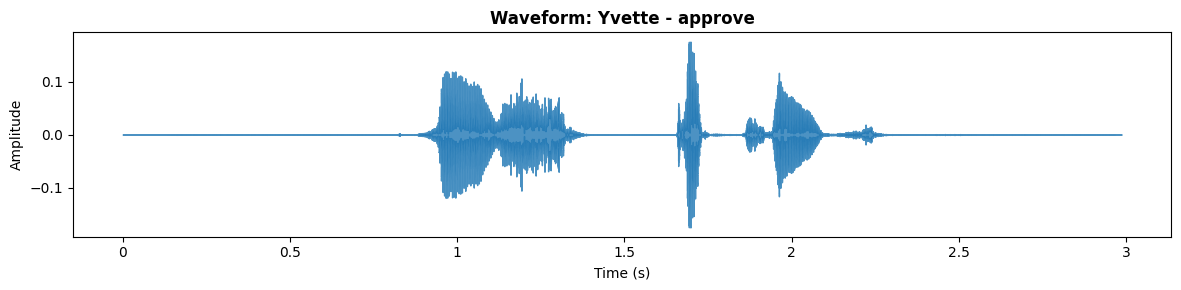

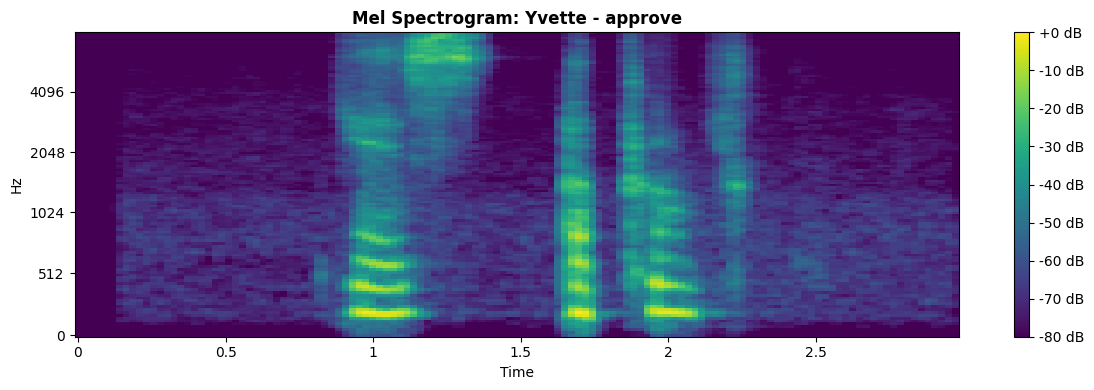


Member: Innocente | Command: approve | Duration: 2.58s


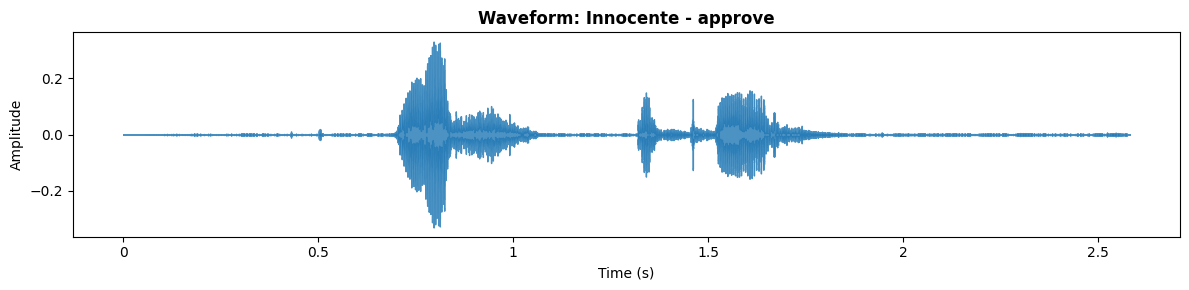

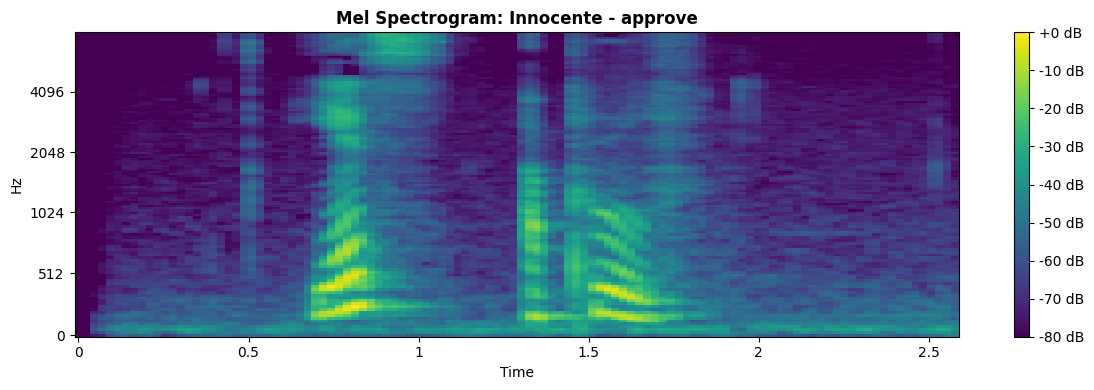



3. Displaying augmentations (first audio)...

Augmentations Preview: Kellen - confirm

--- ORIGINAL ---


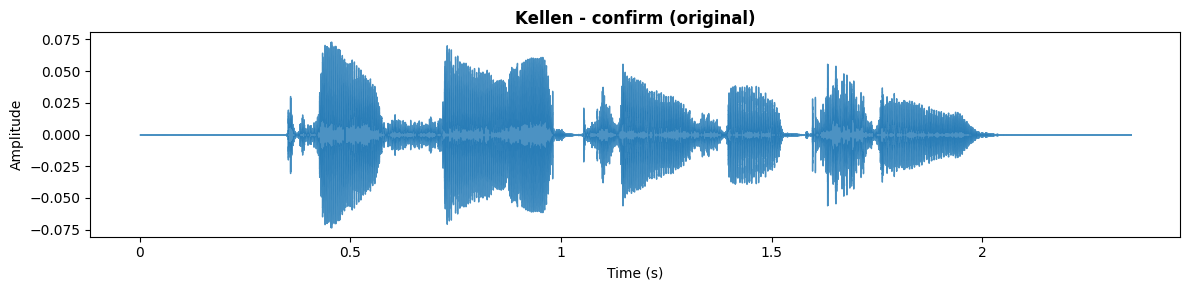

--- PITCH SHIFT ---


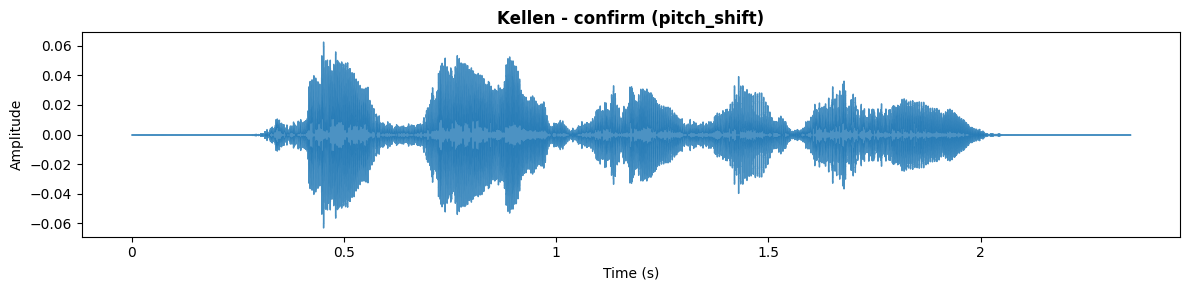

--- TIME STRETCH ---


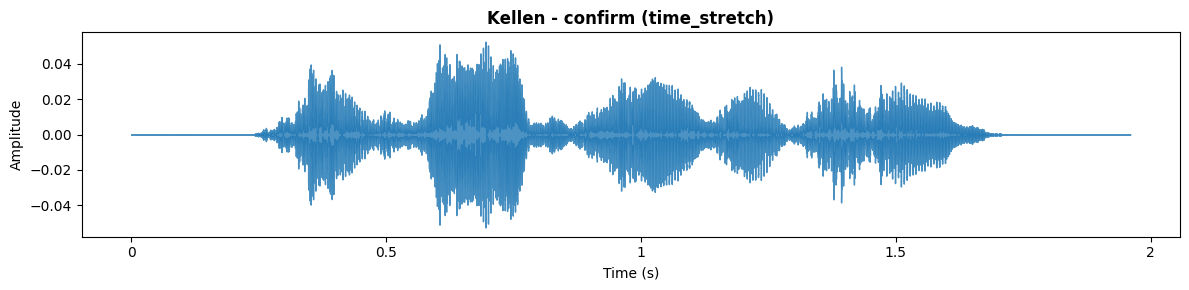

--- ADD NOISE ---


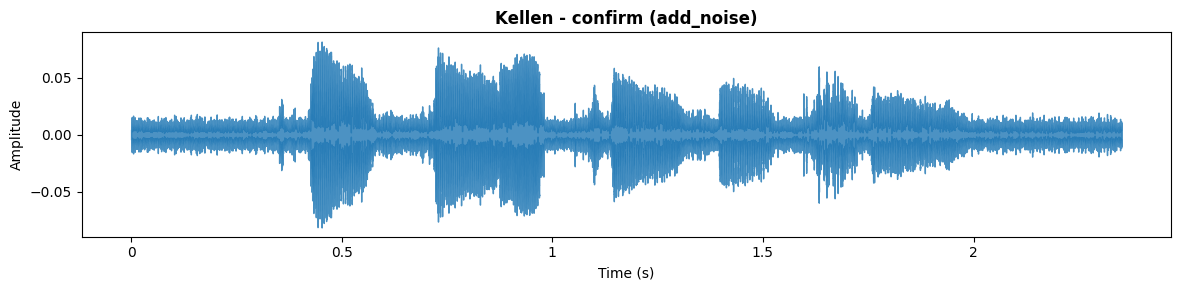

--- SPEED CHANGE ---


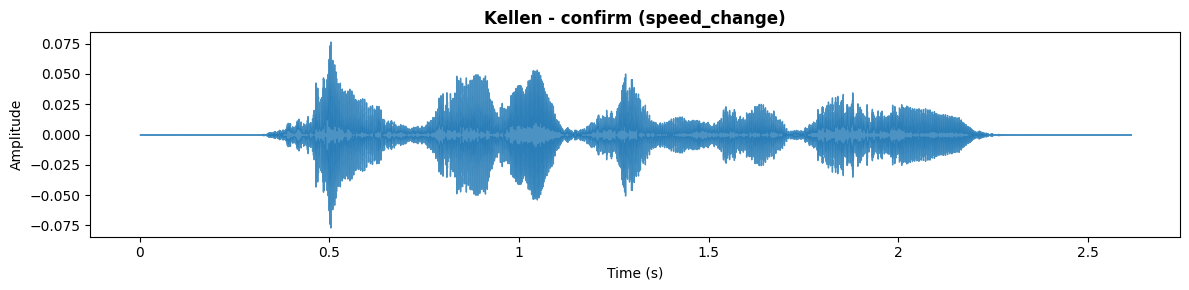


4. Extracting features from all audio files...

Processing 8 audio files...

✓ Processed 1/8: Kellen - confirm
✓ Processed 2/8: Kellen - approve
✓ Processed 3/8: Hortance - approve
✓ Processed 4/8: Hortance - confirm
✓ Processed 5/8: Yvette - approve
✓ Processed 6/8: Yvette - confirm
✓ Processed 7/8: Innocente - approve
✓ Processed 8/8: Innocente - confirm

✓ Features saved to /content/audio_features.csv
✓ You can download it from the Colab files panel on the left
✓ Total feature rows: 40
✓ Feature dimensions: 40

SUMMARY
Members found: 4
Commands found: ['confirm' 'approve']
Total augmented samples: 40

Feature breakdown:
- MFCC features: 26 (13 means + 13 stds)
- Spectral features: 8
- Energy features: 4
- Tempo features: 2
- Total: 40 features per sample

First few rows of features:
   member  command  augmentation  duration
0  Kellen  confirm      original  2.352018
1  Kellen  confirm   pitch_shift  2.352018
2  Kellen  confirm  time_stretch  1.960000
3  Kellen  confirm     add_noi

In [25]:
print("=" * 60)
print("AUDIO PROCESSING & FEATURE EXTRACTION PIPELINE")
print("=" * 60)

# Load audio files
print("\n1. Loading audio files...")
audio_data = load_audio_files(AUDIO_DIR)
print(f"\n✓ Loaded {len(audio_data)} audio files")

if len(audio_data) == 0:
    print("❌ No audio files found! Please check AUDIO_DIR path.")
else:
    # Display summary
    members = set([a['member'] for a in audio_data])
    commands = set([a['command'] for a in audio_data])
    print(f"\nMembers found: {members}")
    print(f"Commands found: {commands}")

    # Display waveforms and spectrograms
    print("\n2. Displaying audio samples...")
    display_audio_samples(audio_data, DISPLAY_TYPE)

    # Show augmentations for first audio
    print("\n3. Displaying augmentations (first audio)...")
    display_augmentations(audio_data[0])

    # Extract and save features
    print("\n4. Extracting features from all audio files...")
    features_df = process_and_save_features(audio_data)

    # Display summary
    print("\n" + "=" * 60)
    print("SUMMARY")
    print("=" * 60)
    print(f"Members found: {features_df['member'].nunique()}")
    print(f"Commands found: {features_df['command'].unique()}")
    print(f"Total augmented samples: {len(features_df)}")
    print("\nFeature breakdown:")
    print("- MFCC features: 26 (13 means + 13 stds)")
    print("- Spectral features: 8")
    print("- Energy features: 4")
    print("- Tempo features: 2")
    print("- Total: 40 features per sample")
    print("\nFirst few rows of features:")
    print(features_df[['member', 'command', 'augmentation', 'duration']].head(10))